# Starcraft Kiting

Suppose you are a maurader being chased by a zealot. Which position should you move to, to evade the zealot while your weapon is reloading?

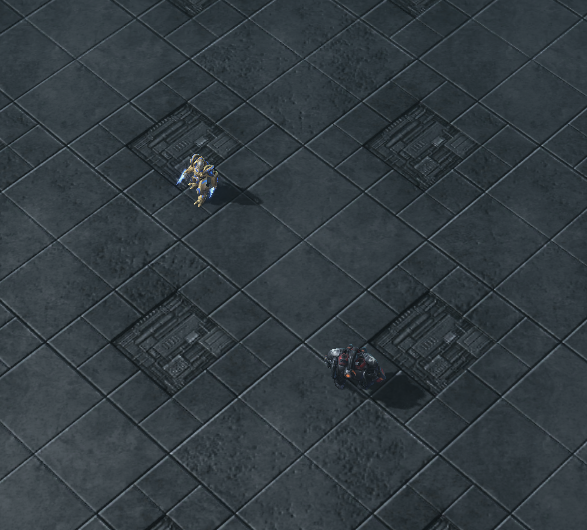

A simple algorithm would be to go in the opposite direction as the zealot, but what if there is a wall in the way? Or other threats nearby? Multiple zealots chasing you?

This notebook outlines an approach to "score" target locations based on how well the path avoids threats and walls.


In [148]:
import numpy as np
import numpy.typing as npt
from scipy import signal
from IPython.display import SVG, display
import xml.etree.ElementTree as ET
from typing import Generator

In [105]:
Point = tuple[int, int]
FPoint = tuple[float, float]
Grid = npt.NDArray
Size = tuple[int, int]

def in_bounds(pos: Point, grid: Grid) -> bool:
    """ is pos in grid? """
    return pos[0] >= 0 and pos[0] < grid.shape[0] and pos[1] >= 0 and pos[1] < grid.shape[1]

def add_point_deltas(pos: Point, deltas: list[Point], grid) -> list[Point]:
    """ get points that are some delta away from pos if in bounds """
    new_pos = [(pos[0] + d[0], pos[1] + d[1]) for d in deltas]
    return [n_pos for n_pos in new_pos if in_bounds(n_pos, grid)]

def get_ortho_neighbors(pos: Point, grid: Grid) -> list[Point]:
    """ get in bounds orthogonal neighbors of pos """
    deltas = [
        (0, 1),
        (0, -1),
        (1, 0),
        (-1, 0)
    ]
    return add_point_deltas(pos, deltas, grid)

def get_diagonal_neighbors(pos: Point, grid: Grid) -> list[Point]:
    """ get in bounds diagonal neighbors of pos """
    deltas = [
        (1, 1),
        (1, -1),
        (-1, 1),
        (-1, -1)
    ]
    return add_point_deltas(pos, deltas, grid)

def propagate_zeros(grid: Grid):
    """ 
    update grid such that each cell represents the distance to nearest zero.
    I suspect there's a fancier way to do this with convolution
    """
    last_set = np.argwhere(grid == 0)
    next_set = []
    while len(last_set) > 0:
        for pos in last_set:
            pos_dist = grid[pos[0], pos[1]]
            for n in get_ortho_neighbors(pos, grid):
                n_dist = pos_dist + 1
                if grid[n] > n_dist:
                    grid[n] = n_dist
                    next_set.append(n)
            for n in get_diagonal_neighbors(pos, grid):
                n_dist = pos_dist + 1.4
                if grid[n] > n_dist:
                    grid[n] = n_dist
                    next_set.append(n)
        last_set = next_set
        next_set = []

def walk_circle(c: Point, radius: int) -> Generator[Point, None, None]:
    """ get all points that are of some radius away from c """
    for r in range(int(radius * np.sqrt(0.5))):
        d = int(np.sqrt(radius*radius - r*r))
        yield (c[0] - d, c[1] + r)
        yield (c[0] + d, c[1] + r)
        yield (c[0] - d, c[1] - r)
        yield (c[0] + d, c[1] - r)
        yield (c[0] + r, c[1] - d)
        yield (c[0] + r, c[1] + d)
        yield (c[0] - r, c[1] - d)
        yield (c[0] - r, c[1] + d)

def draw_points(size: Size, points: list[Point]) -> Grid:
    """ create zero grid where point positions are 1 if in bounds """
    grid = np.zeros(size, np.uint8)
    for pos in points:
        if in_bounds(pos, grid):
            grid[pos] = 1
    return grid

def draw_circle(size: Size, c: Point, radius: int) -> Grid:
    """ set circle of points to 1 on the grid """
    return draw_points(size, walk_circle(c, radius))

def draw_line(size: Size, p0: Point, p1: Point) -> Grid:
    """ set line of points to 1 on the grid """
    return draw_points(size, line(p0, p1))

def lerp(start: int, end: int, t: float) -> float:
    """ linear interpolate """
    return start * (1.0 - t) + end * t

def lerp_point(p0: Point, p1: Point, t: float) -> FPoint:
    """ get point that is interpolated between p0 and p1 """
    return (lerp(p0[0], p1[0], t), lerp(p0[1], p1[1], t))

def diagonal_distance(p0: Point, p1: Point) -> int:
    dx = p1[0] - p0[0]
    dy = p1[1] - p0[1]
    return max(abs(dx), abs(dy))

def round_point(p: FPoint) -> Point:
    return (round(p[0]), round(p[1]))

def line(p0: Point, p1: Point) -> list[Point]:
    """ get points on grid from p0 to p1 """
    points = []
    N = diagonal_distance(p0, p1)
    for step in range(N+1):
        t = step / N if step != 0 else 0.0
        points.append(round_point(lerp_point(p0, p1, t)))
    return points

def max_pos(grid: Grid) -> Point:
    """ what position on the grid has the highest number """
    return np.unravel_index(np.argmax(grid, axis=None), grid.shape)

def score_path(grid: Grid, p0: Point, p1: Point) -> int:
    """ what is the mean number on the path from p0 to p1? """
    points = line(p0, p1)
    return sum([grid[p] for p in points]) / len(points)

def max_dest(grid: Grid, start:Point, dests:list[Point]) -> Point:
    """ which destination has the highest score from start? """
    max_score = 0
    max_dest = None
    for dest in dests:
        score = score_path(grid, start, dest)
        if score > max_score:
            max_score = score
            max_dest = dest
    return max_dest

def max_path(grid: Grid, start:Point, distance: int) -> Point:
    """ what point has the max scoring path that is some distance from start?  """
    return max_dest(grid, start, walk_circle(start, distance))

In [106]:
def draw_grid(grid, highlight_grid=None):
    shape = grid.shape
    max_val = np.max(grid)
    svg = ET.fromstring(f'<svg width="{21*shape[0]}" height="{21*shape[1]}" />')
    for x, col in enumerate(grid):
        for y, cell in enumerate(col):
            color_val = 255 * cell // max_val
            color = f'rgb({color_val}, {color_val}, {color_val})'
            svg.append(ET.fromstring(f'<rect width="20" height="20" x="{x*21}" y="{y*21}" fill="{color}" stroke="gray" />'))
            if highlight_grid is not None and highlight_grid[x,y]==1:
                svg.append(ET.fromstring(f'<rect width="20" height="20" x="{x*21}" y="{y*21}" fill="#ff000033" stroke="red" />'))
            
            
    display(SVG(ET.tostring(svg)))

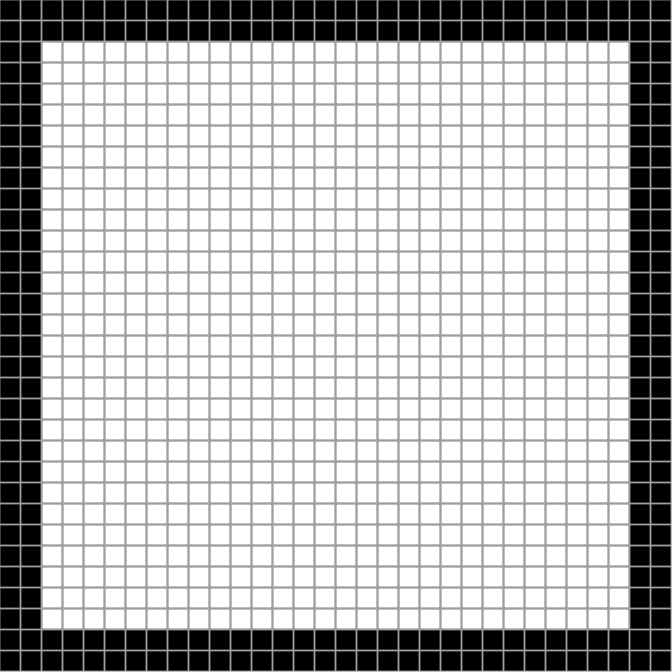

In [107]:
pathing_grid = np.load('pathing_grid.npy')
grid_size = pathing_grid.shape
draw_grid(pathing_grid)

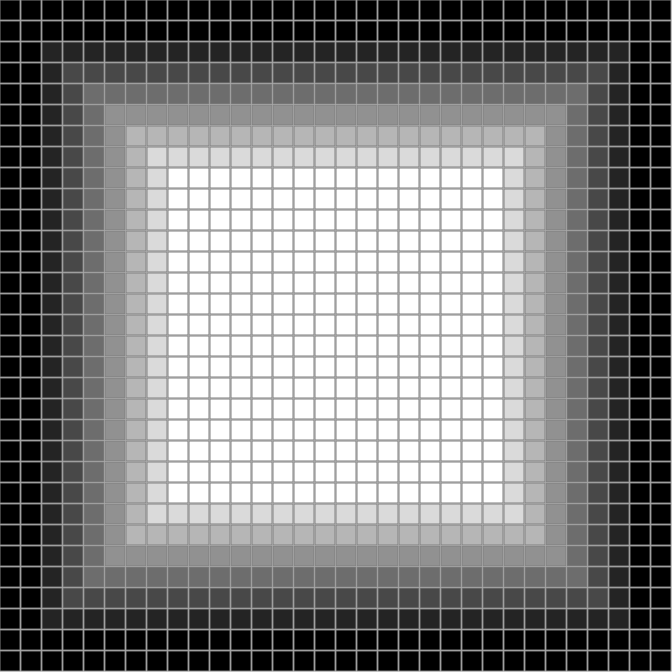

In [115]:
wall_distance_grid = np.zeros(grid_size, dtype=np.float32)
wall_distance_grid[:] = 7
wall_distance_grid *= pathing_grid
propagate_zeros(wall_distance_grid)
wall_distance_grid *= 10 / 7
draw_grid(wall_distance_grid)


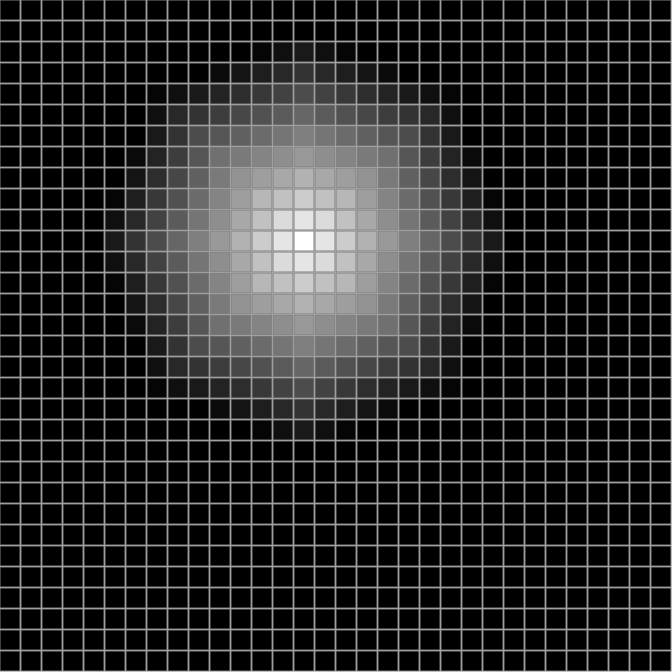

In [116]:
enemy_pos = (14, 11)
enemy_distance_grid = np.zeros(grid_size, dtype=np.float32)
enemy_distance_grid[:] = 10
enemy_distance_grid[enemy_pos] = 0
propagate_zeros(enemy_distance_grid)
enemy_distance_grid = 10 - enemy_distance_grid
draw_grid(enemy_distance_grid)

In [117]:
my_pos = (19, 15)
target_distance = 6
target_circle = draw_circle(grid_size, my_pos, target_distance)

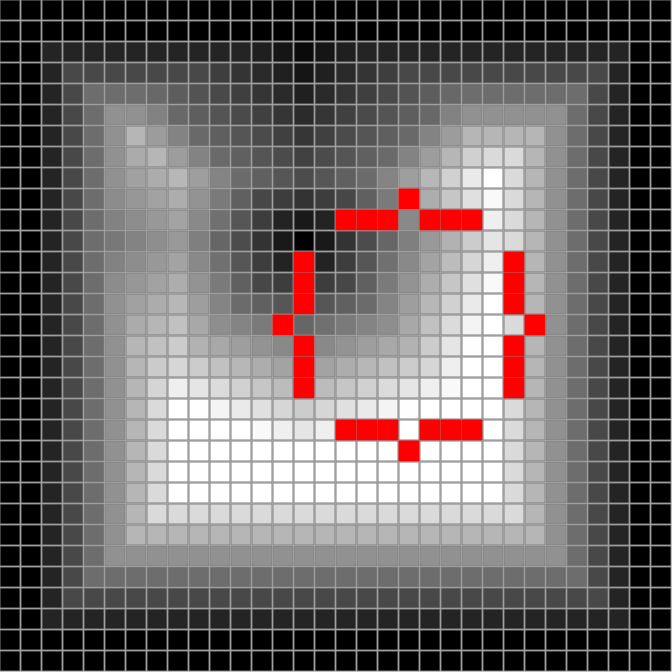

In [118]:
score_grid = (wall_distance_grid - enemy_distance_grid) * pathing_grid
np.clip(score_grid, 0, None, out=score_grid)
draw_grid(score_grid, target_circle)

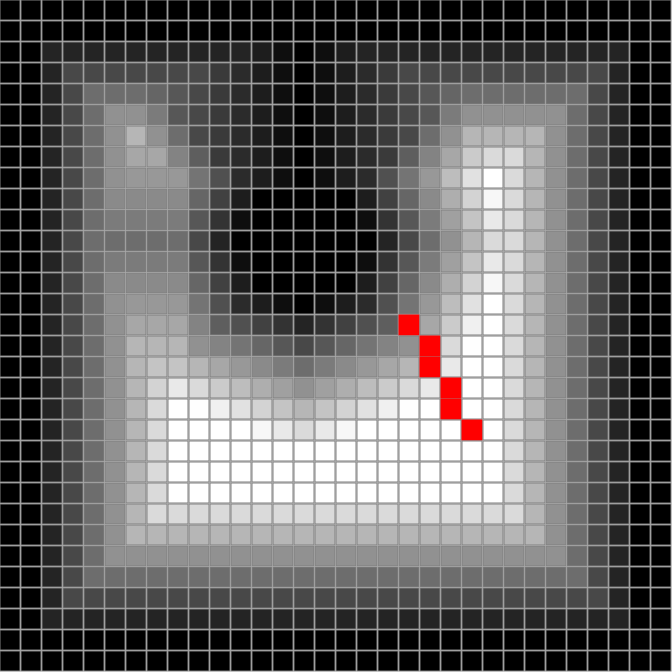

(22, 20)

In [114]:
best_path = max_path(score_grid, my_pos, target_distance)
draw_grid(score_grid, draw_line(grid_size, my_pos, best_path))
best_path

Our algorithm for generating potential fields from enemy units is eerily similar to convolution. Currently we are taking a set of points and setting them to zero on the grid and then calculating the distance from the nearest zero for each square and we have some maximum value that we initialize the grid with. This is basically an altitude map of a cone. However, if the cone shape has already been calculated, then we can convolve it with the enemy points as ones instead of zeros and we end up with the same result. One small difference is that if there were two enemies, then the two cones would be additive instead of the maximum value of the two cones. I think that's actually a more optimal solution. If I had to choose between running past 1 zealot or 2, I should choose 1. The only problem with convolution is that I lose some control over propagation. For example, I wouldn't be able to calculate the relative safety of hiding behind a barrier.

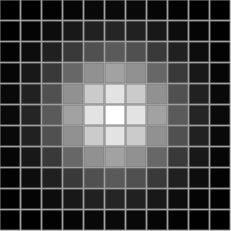

In [187]:


test_grid = np.zeros((11, 11), dtype=np.float32)
test_grid[5,5] = 1
kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])
for _ in range(6):
    test_grid = signal.convolve2d(test_grid, kernel, mode='same')
test_grid /= test_grid[5,5]
draw_grid(test_grid)

Hmm... That's almost a cone. It's technically a Gaussian distribution. Dunno if that's better or worse.

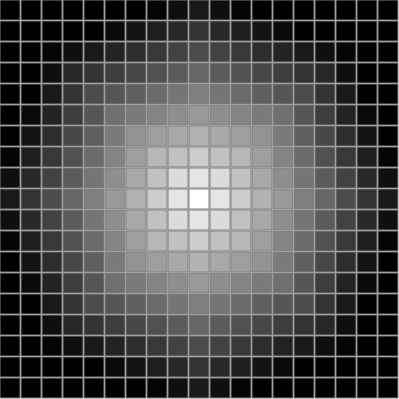

In [146]:
splotch = np.zeros((19,19), dtype=np.float32)
splotch[:] = 10
splotch[9,9] = 0
propagate_zeros(splotch)
splotch = 10 - splotch
draw_grid(splotch)

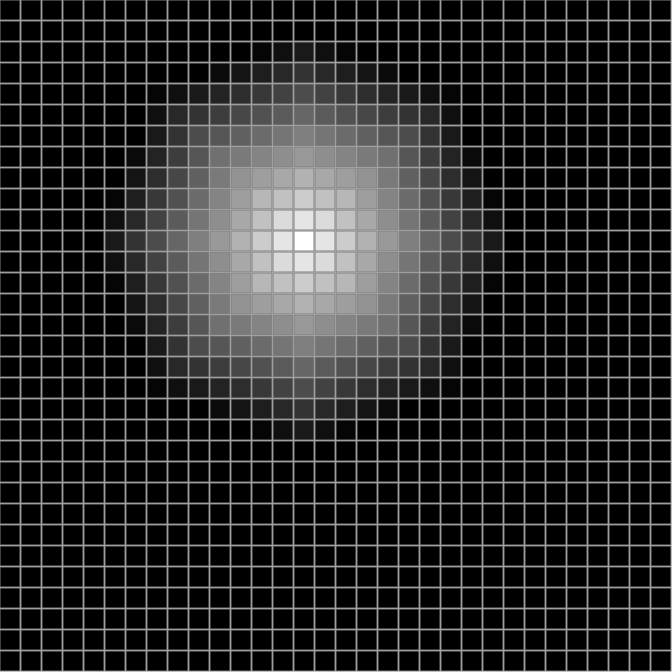

In [150]:
test_enemy_grid = np.zeros(grid_size, np.float32)
test_enemy_grid[enemy_pos] = 1
test_enemy_grid = signal.convolve2d(test_enemy_grid, splotch, 'same')
draw_grid(test_enemy_grid)